Before jumping into the project, I want to comment on this dataset. Overall, I think this dataset is pretty clean with a considerable amount of data, which means that the prediction will be correct to some extent. The features are various and related, including some basic features of healthcare field such as gender, age, bmi, smoking status, etc. In my opinion, this dataset (and this project) is worth practicing for any beginner of Data Science field.

In [1]:
# Import InteractiveShell to see all of the outcomes
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [2]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score

In [3]:
# Load the dataset
insu = pd.read_csv('/kaggle/input/insurance/insurance.csv')

**I. OVERVIEW**

I'll take a look at some basic statistics of the dataset to check if there is anything we should notice.

In [4]:
# Check the first and last 5 rows of the dataset
insu.head()
print( )
insu.tail( )

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


,age,sex,bmi,children,smoker,region,charges
1333,50,male,30.97,3,no,northwest,10600.5483
1334,18,female,31.92,0,no,northeast,2205.9808
1335,18,female,36.85,0,no,southeast,1629.8335
1336,21,female,25.80,0,no,southwest,2007.9450
1337,61,female,29.07,0,yes,northwest,29141.3603


In [5]:
# Check some basic characteristics of the dataset
insu.describe()
print( )
insu.info()
print( )

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB



**II. GRAPHING AND COMPUTING CORRELATION COEFFICIENTS**

After carefully checking, it seems like the dataset is clean without any missing values. We will start graphing and computing to see the correlation and get some sense before training our ML model(s).

array([[<Axes: title={'center': 'age'}>, <Axes: title={'center': 'bmi'}>],
       [<Axes: title={'center': 'children'}>,
        <Axes: title={'center': 'charges'}>]], dtype=object)

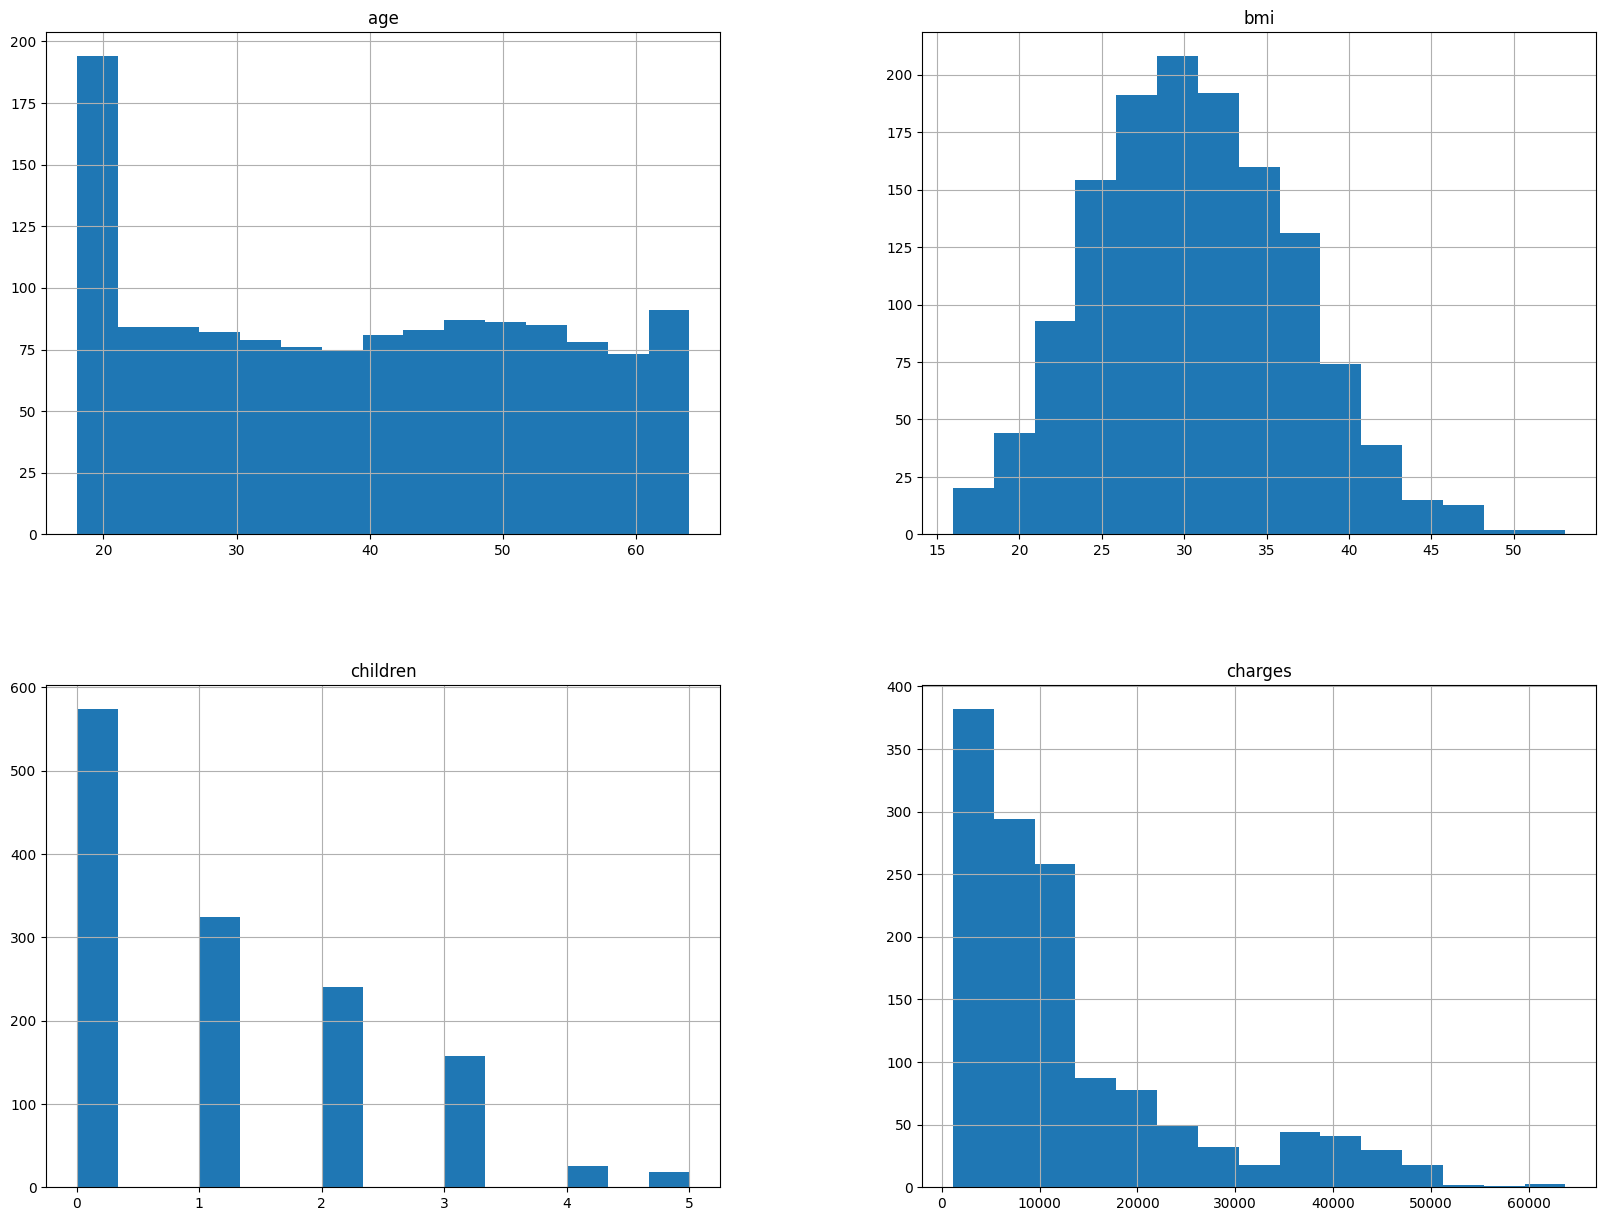

In [6]:
# Plot histograms for each numerical feature
insu.hist(
    bins = 15,
    figsize = (20, 15)
)

In [7]:
# Select numerical columns
numerical_insu = insu.select_dtypes(include=['number'])

# Calculate correlation
corr_matrix = numerical_insu.corr()
corr_matrix

,age,bmi,children,charges
age,1.000000,0.109272,0.042469,0.299008
bmi,0.109272,1.000000,0.012759,0.198341
children,0.042469,0.012759,1.000000,0.067998
charges,0.299008,0.198341,0.067998,1.000000


The most significant correlation that we see here is the one between charges and age (~0.3). We can graph some scatterplots to better realize the correlation coefficients.  

array([[<Axes: xlabel='charges', ylabel='charges'>,
        <Axes: xlabel='age', ylabel='charges'>,
        <Axes: xlabel='bmi', ylabel='charges'>,
        <Axes: xlabel='children', ylabel='charges'>],
       [<Axes: xlabel='charges', ylabel='age'>,
        <Axes: xlabel='age', ylabel='age'>,
        <Axes: xlabel='bmi', ylabel='age'>,
        <Axes: xlabel='children', ylabel='age'>],
       [<Axes: xlabel='charges', ylabel='bmi'>,
        <Axes: xlabel='age', ylabel='bmi'>,
        <Axes: xlabel='bmi', ylabel='bmi'>,
        <Axes: xlabel='children', ylabel='bmi'>],
       [<Axes: xlabel='charges', ylabel='children'>,
        <Axes: xlabel='age', ylabel='children'>,
        <Axes: xlabel='bmi', ylabel='children'>,
        <Axes: xlabel='children', ylabel='children'>]], dtype=object)

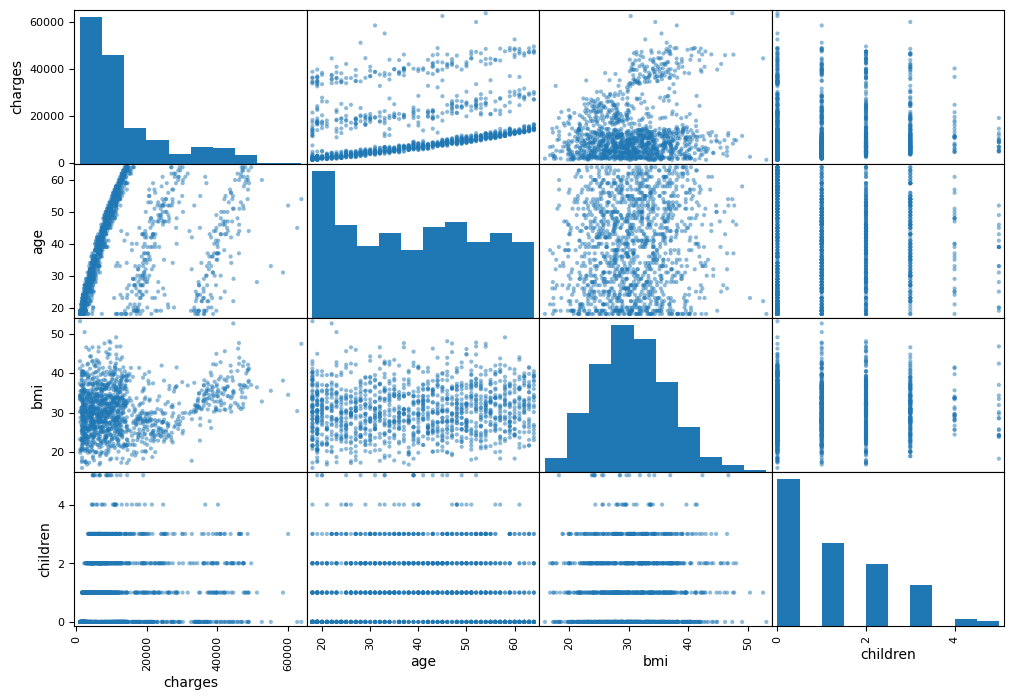

In [8]:
# Graph the scatterplots
attributes = ['charges', 'age', 'bmi', 'children']
scatter_matrix(insu[attributes], figsize = (12, 8))

**III. TRAIN A LINEAR REGRESSION MODEL**

I will start with the most basic model and then calculate its RMSE. However, looking at the scatterplots above, I guess that linear regression might not be our best choice, but we will see.

In [9]:
# Define the features and the target (charges) as Numpy arrays
y = np.c_[insu['charges']] #target
X = insu.drop('charges', axis = 1)

# Check the dimensions of X and y
y.shape
X.shape

(1338, 1)

(1338, 6)

In [10]:
# Provide a list of numerical features and a list of categorical features
num_features = ['age', 'bmi', 'children']
cat_features = ['sex', 'smoker', 'region']

In [11]:
# Create a pipeline to process numerical features
num_pipline = Pipeline([
    ('imputer', SimpleImputer(strategy = 'median')), # replace missing values, if any, with the median of a feature
    ('std_scaler', StandardScaler()) # standardize a feature
  ])

# Create a full pipeline to process both numerical and categorical features
full_pipline = ColumnTransformer([
  ('num', num_pipline, num_features), # process numerical features using the numerical feature pipline created
  ('cat', OneHotEncoder(), cat_features) # process categorical features using one-hot encoder
  ])

In [12]:
# Split data into train and test datasets
X_train, X_test, y_train, y_test = train_test_split(
    X, # features
    y, # target
    test_size = 0.2, # 20% data to be included in the test set
    random_state = 42 # specify random seed for results replication
  )

In [13]:
# Fit and transform the data using the full pipeline
X_train = full_pipline.fit_transform(X_train)

X_test = full_pipline.transform(X_test)

In [14]:
# Train the linear regression model
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

LinearRegression()

In [15]:
# Try predicting some instances from the test set
print(lin_reg.predict(X_train[:5])) # predict the first 5 instances
print('\n')

# Print the true values
print(y_train[:5])

[[ 7094.54007011]
 [ 8344.72998713]
 [ 9153.77419778]
 [11128.37948103]
 [10088.00517924]]


[[ 9193.8385 ]
 [ 8534.6718 ]
 [27117.99378]
 [ 8596.8278 ]
 [12475.3513 ]]


**IV. CALCULATE THE ROOT MEAN SQUARE ERROR (RMSE) USING THE TEST SET**

As we see above, the predictions seem to be not verry close. I will compute the RSME and compare it to some other models (KNN, Decision Tree, Random Forest) to see which give us the closest predictions.

In [16]:
# Calculate root mean square error (rmse) using the test set
y_pred_lin = lin_reg.predict(X_test) # predict charges
lin_mse = mean_squared_error(y_pred_lin, y_test) # calculate mean squared error
lin_rmse = np.sqrt(lin_mse) # calculate rmse
print(f'The RMSE of Linear Regression is {lin_rmse}')

The RMSE of Linear Regression is 5796.284659276274


> Firstly, I will calculate KNN's model RMSE

In [17]:
# Use cross-validation to find the hyperparameter (n_neighbors)
knn_mse_scores = []
for k in range(1, 11):  # Test k = 1 to 10
    knn_model = KNeighborsRegressor(n_neighbors=k)
    knn_scores = cross_val_score(knn_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    knn_mse_scores.append(-knn_scores.mean())  # Convert to positive MSE

# Find best k (the one that minimizes the MSE)
best_k_knn = knn_mse_scores.index(min(knn_mse_scores)) + 1
print("Best n_neighbors:", best_k_knn)

Best n_neighbors: 6


In [18]:
# Fit the model after knowing the best n_neighbors = 6
knn_model = KNeighborsRegressor(n_neighbors = 6)
knn_model.fit(X_train, y_train)
y_pred_knn = knn_model.predict(X_test) # predict charges
knn_mse = mean_squared_error(y_pred_knn, y_test) # calculate mean squared error
knn_rmse = np.sqrt(knn_mse) # calculate rmse
print(f"The RSME of the KNN regression is: {knn_rmse}")

KNeighborsRegressor(n_neighbors=6)

The RSME of the KNN regression is: 6148.970607303948


> Secondly, I will calculate Decision Tree's RMSE

In [19]:
# Use cross-validation to find the hyperparameter (max_depth)
tree_mse_scores = []
for depth in range(1, 11):  # Test max_depth = 1 to 10
    tree_reg = DecisionTreeRegressor(max_depth=depth, random_state = 42)
    tree_scores = cross_val_score(tree_reg, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    tree_mse_scores.append(-tree_scores.mean())  # Convert to positive MSE

best_depth = tree_mse_scores.index(min(tree_mse_scores)) + 1
print("Best depth Decision Tree:", best_depth)

Best depth Decision Tree: 4


In [20]:
# Fit the model after knowing the best depth = 4
tree_reg = DecisionTreeRegressor(max_depth=4, random_state=42)
tree_reg.fit(X_train, y_train)
y_pred_tree = tree_reg.predict(X_test) # predict charges
tree_mse = mean_squared_error(y_pred_tree, y_test) # calculate mean squared error
tree_rmse = np.sqrt(tree_mse) # calculate rmse
print(f"The RSME of the Decision Tree model is: {tree_rmse}")

DecisionTreeRegressor(max_depth=4, random_state=42)

The RSME of the Decision Tree model is: 4592.764309715603


> Lastly, we will do the Random Forest.

In [21]:
# Use cross-validation to find the hyperparameters (n_estimators and max_depth)
forest_mse_scores = []
for n_trees in [50, 100, 200]:  # Test different numbers of trees
    for depth in [5, 10, None]:  # Test different max_depth values
        forest_reg = RandomForestRegressor(n_estimators=n_trees, max_depth=depth, random_state=42)
        forest_scores = cross_val_score(forest_reg, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
        forest_mse_scores.append((n_trees, depth, -np.mean(forest_scores)))

# Find the best parameters
best_params = min(forest_mse_scores, key=lambda x: x[2])  # Find the smallest MSE
best_n_estimators, best_max_depth, best_mse = best_params
print(f"Best n_estimators: {best_n_estimators}, Best max_depth: {best_max_depth}")

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed whe

Best n_estimators: 200, Best max_depth: 5


In [22]:
# Fit the model after knowing the best estimators = 200, best depth = 5
forest_reg = RandomForestRegressor(n_estimators=200, max_depth=5, random_state=42)
forest_reg.fit(X_train, y_train)
y_pred_forest = forest_reg.predict(X_test) # predict charges
forest_mse = mean_squared_error(y_pred_forest, y_test) # calculate mean squared error
forest_rmse = np.sqrt(forest_mse) # calculate rmse
print(f"The RSME of the Random Forest model is: {forest_rmse}")

<ipython-input-22-983ee3bffc81>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  forest_reg.fit(X_train, y_train)


RandomForestRegressor(max_depth=5, n_estimators=200, random_state=42)

The RSME of the Random Forest model is: 4430.158377389173


We see that the RMSE of KNN > linear regression model > Decision Tree > Random Forest, which means that the random forest model is the most efficient in predicting future values. That's the end of this project.